In [1]:
import numpy as np
from datascience import *
from datetime import datetime
from scipy import stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
import random
np.set_printoptions(threshold=np.inf)

In [2]:
#setup
#INPUT START
main_table1 = Table.read_table("/Users/jay/Desktop/Work/客群分析/data/訂單-2003_2103.csv")
#INPUT END
is_pet = []
for product in main_table1.column("多規格名稱一"):
    if ("狗" not in product and "貓" not in product and "寵物" not in product and "pet" not in product):
        is_pet.append("not pet product")
    else:
        is_pet.append("is pet product")
main_table1 = main_table1.with_column("pet product", is_pet)
main_table = main_table1.where("pet product", are.equal_to("not pet product")).where("購買人電子信箱", are.not_equal_to("nan"))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
#setup
emails = main_table.column("購買人電子信箱")
user_data = {}
user_list = []
phone_number_list = []
user_name_list = []
num_purchases_list = []
total_expenditure_list = []
average_expenditure_list = []
first_purchase_list = []
first_purchase_days_list = []
last_purchase_list = []
last_purchase_days_list = []
num_items_list = []
account_type_list = []
frequency_score_list = []
user_data_key = user_data.keys()

def time_since_march31(time):
    year = int(time[:4])
    month = int(time[5:7])
    day = int(time[8:10])
    if year == 2020:
        month = 15 - month
    else:
        month = 3 - month
    return int((month * 30.5) + (31 - day))

#build dictionary
for email in emails:
    if email not in user_data:
        user_data[email] = {"name": "",
                            "phone number": 0, 
                            "number of orders": 0, 
                            "number of items purchased": 0,
                            "total expenditure": 0, 
                            "average expenditure": 0,
                            "first purchase": "",
                            "first purchase (days)": -1, 
                            "last purchase": "", 
                            "last purchase (days)": 0, 
                            "account type": "", 
                            "frequency score": None, 
                            "expenditure score": None,
                            "recency score": None,}
        user_list.append(email)
        
orders = main_table.column("訂單編號")
expenditure_per_item = main_table.column("小計")
purchase_time = main_table.column("購買日期")
account_type = main_table.column("會員等級")
items_list = main_table.column("商品編號")
phone_number = main_table.column("購買人電話")
name = main_table.column("購買人姓名")

for i in range(main_table.num_rows):
    person = emails[i]
    if (i+1 < len(orders) and orders[i] != orders[i+1]) or i == (len(orders)-1):
        user_data[emails[i]]["number of orders"] += 1
        
    user_data[person]["total expenditure"] += int(expenditure_per_item[i])
    
    user_data[person]["last purchase"] = purchase_time[i]
    user_data[person]["last purchase (days)"] = time_since_march31(purchase_time[i])
    
    if user_data[person]["first purchase"] == "":
        user_data[person]["first purchase"] = purchase_time[i]
        user_data[person]["first purchase (days)"] = time_since_march31(purchase_time[i])
    
    if account_type[i] != "nan":
        user_data[person]["account type"] = account_type[i]
    else:
        user_data[person]["account type"] = "訪客"
        
    if user_data[person]["phone number"] == 0:
        user_data[person]["phone number"] = "0" + str(int(phone_number[i]))
        
    if user_data[person]["name"] == "":
        user_data[person]["name"] = name[i]
        
    if items_list[i] != "redeem_discount" and items_list[i] != "memberLevel-0" and items_list[i] != "memberLevel":
        user_data[person]["number of items purchased"] += 1    
#lists
for user in user_data_key:
    user_data[user]["average expenditure"] = int(user_data[user]["total expenditure"] / user_data[user]["number of orders"])
    
    if user_data[user]["first purchase (days)"] - user_data[user]["last purchase (days)"] != 0:
        user_data[user]["frequency score"] = (user_data[user]["number of items purchased"] /
                                              (user_data[user]["first purchase (days)"] -
                                               user_data[user]["last purchase (days)"])) * 100
    else:
        user_data[user]["frequency score"] = 0
    
    num_purchases_list.append(user_data[user]["number of orders"])
    total_expenditure_list.append(user_data[user]["total expenditure"])
    average_expenditure_list.append(user_data[user]["average expenditure"])
    first_purchase_list.append(user_data[user]["first purchase"])
    first_purchase_days_list.append(user_data[user]["first purchase (days)"])
    last_purchase_list.append(user_data[user]["last purchase"])
    last_purchase_days_list.append(user_data[user]["last purchase (days)"])
    account_type_list.append(user_data[user]["account type"])
    phone_number_list.append(user_data[user]["phone number"])
    user_name_list.append(user_data[user]["name"])
    num_items_list.append(user_data[user]["number of items purchased"])
    frequency_score_list.append(user_data[user]["frequency score"])

user_data_table = Table().with_columns("姓名", user_name_list,
                                       "電子信箱", user_list,
                                       "電話", phone_number_list, 
                                       "會員等級", account_type_list,
                                       "第一次消費時間", first_purchase_list,
                                       "第一次消費時間（天數）", first_purchase_days_list,
                                       "最近一次消費時間", last_purchase_list,
                                       "最近一次消費時間（天數）", last_purchase_days_list,
                                       "消費次數", num_purchases_list,
                                       "購賣商品數", num_items_list,
                                       "總消費金額", total_expenditure_list,
                                       "平均消費金額", average_expenditure_list,
                                       "消費頻率分數（產品/天）", frequency_score_list,
                                       )

In [4]:
#scores
frequency_scores = user_data_table.where("消費頻率分數（產品/天）", are.not_equal_to(0)).column("消費頻率分數（產品/天）")
expenditure_scores = user_data_table.column("總消費金額")
recency_scores =user_data_table.column("最近一次消費時間（天數）")

frequency_score_list1 = []
recency_score_list = []
expenditure_score_list = []
overall_score_list = []

for score in frequency_score_list:
    if score != 0:
        frequency_score_list1.append(int(stats.percentileofscore(frequency_scores, score)))
    else:
        frequency_score_list1.append(0)
        
for expenditure in expenditure_scores:
    expenditure_score_list.append(int(stats.percentileofscore(expenditure_scores, expenditure)))

for time in recency_scores:
    recency_score_list.append(int(100 - (stats.percentileofscore(recency_scores, time))))
    
for i in range(len(recency_score_list)):
    overall_score_list.append(int((recency_score_list[i] * 0.8 + expenditure_score_list[i] + frequency_score_list1[i]) / 2.8))

user_data_table = user_data_table.with_columns("消費週期分數", recency_score_list,
                                               "消費頻率分數", frequency_score_list1,
                                               "消費金額分數", expenditure_score_list,
                                               "整體分數", overall_score_list).drop("消費頻率分數（產品/天）")

In [5]:
#time tag
premium_user_email_list = user_data_table.where("消費次數", are.above(1)).column("電子信箱")
time_behavior_dict = {}
def get_morning(time):
    hour = int(time[11:13])
    if 8 <= hour <= 10:
        return "morning"
    elif 11 <= hour <= 13:
        return "noon"
    elif 14 <= hour <= 17:
        return "afternoon"
    elif 18 <= hour <= 23:
        return "night"
    elif 0 <= hour <= 3:
        return "late night"
    elif 4 <= hour <= 7:
        return "early morning"

time_array = ["早上", "中午", "下午", "晚上", "深夜", "凌晨"]
def morning_person(array):
    return_text = ""
    max_one = max(array)
    i1 = 0
    for i in array:
        if i == max_one:
            yeee = str(time_array[i1])
            return_text += str(yeee + "/")
            array[i1] = 0
            break
        else:
            i1 += 1
    max_two = max(array)
    i1 = 0
    if max_two > 0:
        for i in array:
            if i == max_two:
                if time_array[i1] != yeee:
                    return_text += str(time_array[i1] + "/")
                break
            else:
                i1 += 1
    return return_text  

for i in range(main_table.num_rows):
    person = main_table.column("購買人電子信箱")[i]
    if person in premium_user_email_list and person not in time_behavior_dict.keys():
        time_behavior_dict[person] = [get_morning(main_table.column("購買日期")[i])]
    elif person in premium_user_email_list and person in time_behavior_dict.keys():
        time_behavior_dict[person].append(get_morning(main_table.column("購買日期")[i]))

for user in time_behavior_dict.keys():
    morning = time_behavior_dict[user].count("morning")
    noon = time_behavior_dict[user].count("noon")
    afternoon = time_behavior_dict[user].count("afternoon")
    night = time_behavior_dict[user].count("night")
    late_night = time_behavior_dict[user].count("late night")
    early_morning = time_behavior_dict[user].count("early morning")
    time_behavior_dict[user] = morning_person([morning, noon, afternoon, night, late_night, early_morning])

behavior_time_list = []
for user in time_behavior_dict.keys():
    behavior_time_list.append(time_behavior_dict[user])
ii = 0
temp = []
for i in range(user_data_table.num_rows):
    if user_data_table.column("消費次數")[i] > 1:
        temp.append(behavior_time_list[ii])
        ii += 1
    else:
        temp.append("")

user_data_table = user_data_table.with_column("消費時段", temp)


In [6]:
#tags
tags_dict = {}
for i in range(main_table.num_rows):
    if main_table.column("購買人電子信箱")[i] not in tags_dict.keys():
        tags_dict[main_table.column("購買人電子信箱")[i]] = main_table.column("多規格名稱一")[i]
    else:
        tags_dict[main_table.column("購買人電子信箱")[i]] += main_table.column("多規格名稱一")[i]
def spending_predictor(i):  
    score = user_data_table.column("消費金額分數")[i]
    if score >= 95 or user_data_table.column("會員等級")[i] == "白金會員":
        return "極高消費"
    elif score >= 75 or user_data_table.column("會員等級")[i] == "高級會員":
        return "高消費"
    else:
        return ""
def working_predictor(i):
    if user_data_table.column("消費時段")[i] != "":
        if "早上" in user_data_table.column("消費時段")[i] and "下午" in user_data_table.column("消費時段")[i]:
            return "非上班族"
        elif "中午" in user_data_table.column("消費時段")[i] and ("晚上" in user_data_table.column("消費時段")[i] or "深夜" in user_data_table.column("消費時段")[i]):
            return "上班族"
        elif (".gov" in user_data_table.column("電子信箱")[i] or
            ".org" in user_data_table.column("電子信箱")[i] or
            ".edu" in user_data_table.column("電子信箱")[i] or
            ".net" in user_data_table.column("電子信箱")[i]):
            return "上班族"
        elif "凌晨" in user_data_table.column("消費時段")[i] and "深夜" in user_data_table.column("消費時段")[i]:
            return "熬夜族"
        else:
            return ""
    else:
        if (".gov" in user_data_table.column("電子信箱")[i] or
            ".org" in user_data_table.column("電子信箱")[i] or
            ".edu" in user_data_table.column("電子信箱")[i] or
            ".net" in user_data_table.column("電子信箱")[i]):
            return "上班族"
        else:
            return ""
def mom_predictor(i):
    if ("兒童" in tags_dict[user_data_table.column("電子信箱")[i]] or 
        "kid" in tags_dict[user_data_table.column("電子信箱")[i]] or 
        "奶瓶" in tags_dict[user_data_table.column("電子信箱")[i]] or
        "鈣多多" in tags_dict[user_data_table.column("電子信箱")[i]] ): 
        return "有小孩"
    else:
        return ""
def group_buy_predictor(i):
    if "團購" in tags_dict[user_data_table.column("電子信箱")[i]]:
        return "團購"
    else:
        return ""
predictor_list = []
for i in range(user_data_table.num_rows):
    lst = ""
    s, w, m, g = spending_predictor(i), working_predictor(i), mom_predictor(i), group_buy_predictor(i)
    if s != "":
        lst += (s + "/")
    if w != "":
        lst += (w + "/")
    if m != "":
        lst += (m + "/")
    if g != "":
        lst += (g + "/")
    predictor_list.append(lst)
    
tags_dict1 = {}
for i in range(main_table.num_rows):
    if main_table.column("購買人電子信箱")[i] not in tags_dict1.keys():
        if main_table.column("商品編號")[i] == "memberLevel":
            tags_dict1[main_table.column("購買人電子信箱")[i]] = "memberLevel-1"
        else:
            tags_dict1[main_table.column("購買人電子信箱")[i]] = main_table.column("商品編號")[i]
    else:
        if main_table.column("商品編號")[i] == "memberLevel":
            tags_dict1[main_table.column("購買人電子信箱")[i]] += "memberLevel-1"
        else:
            tags_dict1[main_table.column("購買人電子信箱")[i]] += main_table.column("商品編號")[i]
def discount_predictor(i):
    memberLevel_0 =  tags_dict1[user_data_table.column("電子信箱")[i]].count("memberLevel-0")
    redeem_discount = tags_dict1[user_data_table.column("電子信箱")[i]].count("redeem_discount")
    memberLevel = tags_dict1[user_data_table.column("電子信箱")[i]].count("memberLevel-1")
    gift = tags_dict[user_data_table.column("電子信箱")[i]].count("贈品")
    coupon = tags_dict1[user_data_table.column("電子信箱")[i]].count("coupon")
    var_lst = [memberLevel_0, redeem_discount, memberLevel, gift, coupon]
    name_lst = ["會員現金積點回饋", "現金積點折抵", "會員滿X元，打X折", "贈品", "coupon"]
    return_text = ""
    for i in range(5):
        if var_lst[i] != 0:
            return_text += (str(name_lst[i]) + "：" + str(var_lst[i]) + "次/")
    return return_text
discount_list = []
for i in range(user_data_table.num_rows):
    lst = discount_predictor(i)
    discount_list.append(lst)
    
user_data_table = user_data_table.with_columns("使用過的優惠", discount_list, "推測標籤", predictor_list).where("總消費金額", are.above(-1))

In [8]:
#客戶表格
user_data_table.sort("整體分數", descending = True).show(10)

#EXPORT
#user_data_table.to_csv("客戶表格.csv")

姓名,電子信箱,電話,會員等級,第一次消費時間,第一次消費時間（天數）,最近一次消費時間,最近一次消費時間（天數）,消費次數,購賣商品數,總消費金額,平均消費金額,消費週期分數,消費頻率分數,消費金額分數,整體分數,消費時段,使用過的優惠,推測標籤
洪嘉莉,hungemily0309@gmail.com,0978577286,一般會員,2021-03-07 21:52:38,24,2021-03-28 20:23:50,3,3,11,5692,1897,98,97,98,97,晚上/,會員現金積點回饋：2次/現金積點折抵：2次/,極高消費/
董碧心,dong0961197800@yahoo.com.tw,0961197800,訪客,2021-03-13 21:12:49,18,2021-03-16 03:09:24,15,2,14,7451,3725,93,99,99,97,晚上/深夜/,,極高消費/
林讌伃,a6joan@yahoo.com.tw,0913515292,訪客,2021-03-21 09:33:58,10,2021-03-25 13:50:54,6,2,5,4051,2025,97,98,96,97,早上/中午/,,極高消費/
韓佳芯,rebecca19831110@yahoo.com.tw,0956765470,一般會員,2021-03-22 03:14:01,9,2021-03-30 23:21:09,1,3,8,4423,1474,99,98,97,97,深夜/晚上/,會員現金積點回饋：2次/現金積點折抵：2次/,極高消費/
翁小雪,snow.1001@yahoo.com.tw,0903042167,一般會員,2021-03-24 21:12:13,7,2021-03-28 15:13:31,3,2,8,3899,1949,98,99,96,97,下午/晚上/,會員現金積點回饋：2次/現金積點折抵：2次/,極高消費/
宋佩珊,snoopy409733@gmail.com,0987967333,一般會員,2021-03-29 08:57:48,2,2021-03-30 14:22:22,1,2,9,3136,1568,99,99,94,97,下午/早上/,會員現金積點回饋：2次/現金積點折抵：2次/,高消費/非上班族/
黃于眞,shoyy1991@gmail.com,0988309986,一般會員,2021-03-22 22:39:20,9,2021-03-24 13:37:36,7,2,4,3000,1500,96,99,93,96,中午/晚上/,會員現金積點回饋：2次/現金積點折抵：2次/,高消費/上班族/
莊羽庭,yuting811228@yahoo.com.tw,0912823278,一般會員,2021-03-23 14:50:11,8,2021-03-28 13:09:23,3,2,6,3149,1574,98,98,94,96,中午/下午/,會員現金積點回饋：1次/現金積點折抵：1次/,高消費/
黃婷筠,miu0516@gmail.com,0916610516,訪客,2021-01-28 01:02:17,64,2021-03-24 22:47:31,7,2,12,7208,3604,96,91,99,95,深夜/晚上/,會員現金積點回饋：1次/現金積點折抵：1次/,極高消費/團購/
潘怡嘉,pennypan316@hotmail.com,0919717519,一般會員,2021-02-23 22:28:15,38,2021-03-29 15:28:27,2,2,9,3143,1571,99,93,94,95,晚上/下午/,會員現金積點回饋：2次/現金積點折抵：2次/,高消費/有小孩/


平均消費分佈
四分位數： 0 650.0 880.0 1103.0 7746
大於4000元：22筆 [4090 4090 4090 4090 4095 4119 4136 4140 4143 4300 4382 4448 4457 4504
 4581 4618 4624 4694 4710 5060 5160 7746]


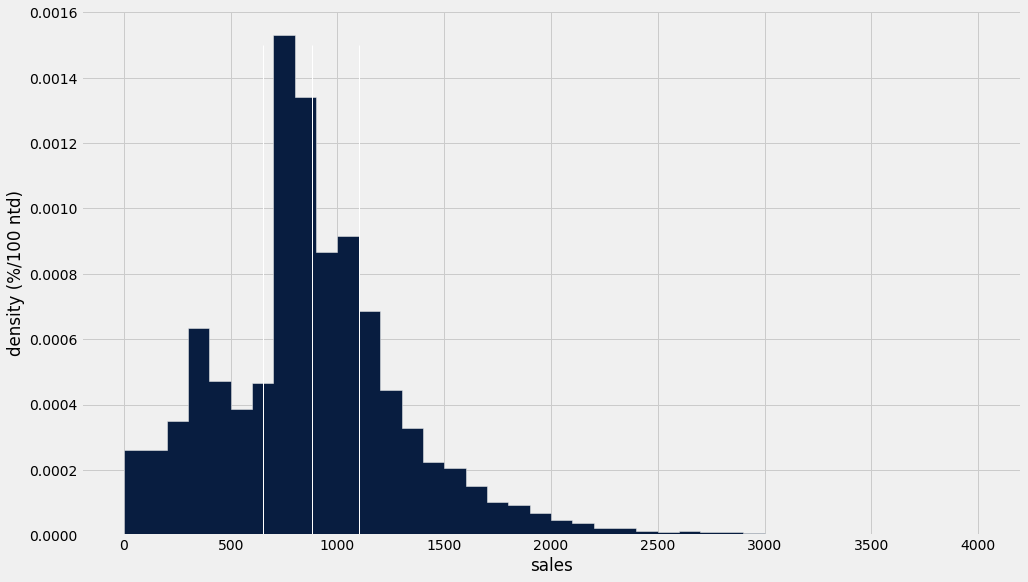

In [9]:
#平均消費分佈
graph, (plot1) = plots.subplots()
graph.set_size_inches(15, 9)
avg_expenditure = user_data_table.column("平均消費金額")
avg_expenditure_4000 = user_data_table.sort("平均消費金額").where("平均消費金額", are.above(4000)).column("平均消費金額")
plots.hist(avg_expenditure, bins = np.arange(0, 4001, 100), histtype = 'stepfilled',color = "#081d40", density = True)
plots.xlabel("sales")
plots.ylabel("density (%/100 ntd)")
print("平均消費分佈")
quads = np.percentile(avg_expenditure, [25, 50, 75])
print("四分位數：", min(avg_expenditure), quads[0], quads[1], quads[2], max(avg_expenditure))
plots.plot([quads[0], quads[0]], [0, 0.0015], color = "white", lw = 1, alpha = 1)
plots.plot([quads[1], quads[1]], [0, 0.0015], color = "white", lw = 1, alpha = 1)
plots.plot([quads[2], quads[2]], [0, 0.0015], color = "white", lw = 1, alpha = 1)
print("大於4000元：" + str(len(avg_expenditure_4000)) + "筆", avg_expenditure_4000)

#EXPORT
#plots.savefig('平均消費分佈.png')

總消費分佈
四分位數： 0 705.0 920.0 1479.0 19374
大於8000元：84筆 [ 8005  8037  8064  8075  8088  8097  8129  8138  8147  8186  8214  8232
  8265  8271  8273  8291  8358  8371  8461  8483  8606  8624  8704  8743
  8769  8798  8961  9063  9069  9192  9225  9253  9304  9349  9371  9376
  9398  9423  9485  9552  9611  9645  9761  9779  9839  9854  9893  9911
  9975 10167 10201 10290 10362 10401 10617 10819 10947 10982 10989 11366
 11399 11415 11497 11651 11718 11898 12113 12157 12706 13083 13346 13371
 13604 13951 13988 14266 14525 14587 14935 15060 15216 15480 15867 19374]


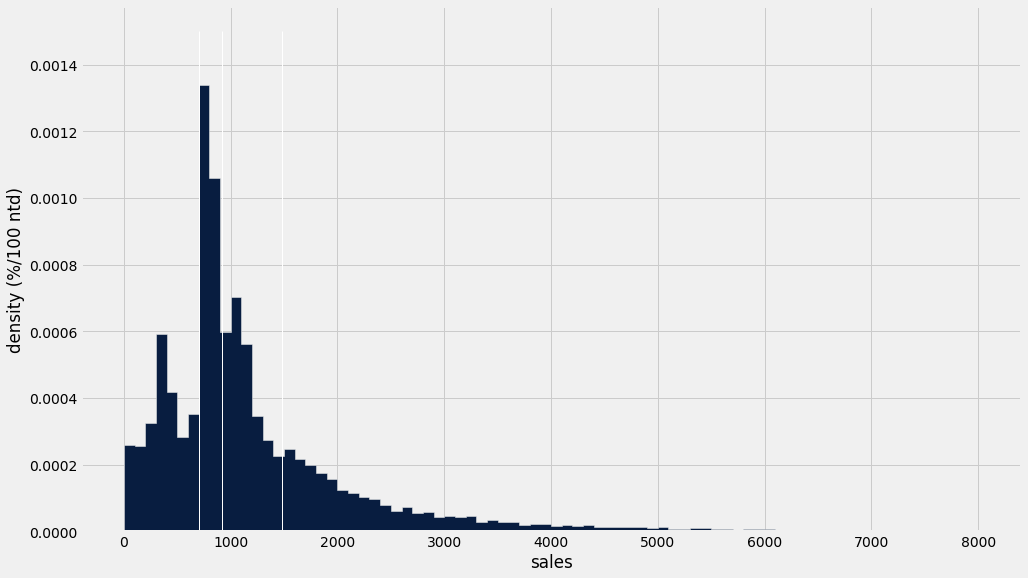

In [9]:
#總消費分佈
graph, (plot1) = plots.subplots()
graph.set_size_inches(15, 9)
total_expenditure = user_data_table.column("總消費金額")
total_expenditure_8000 = user_data_table.sort("總消費金額").where("總消費金額", are.above(8000)).column("總消費金額")
plots.hist(total_expenditure, bins = np.arange(0, 8001, 100), histtype = 'stepfilled',color = "#081d40", density = True)
plots.xlabel("sales")
plots.ylabel("density (%/100 ntd)")
print("總消費分佈")
quads1 = np.percentile(total_expenditure, [25, 50, 75])
print("四分位數：", min(total_expenditure), quads1[0], quads1[1], quads1[2], max(total_expenditure))
plots.plot([quads1[0], quads1[0]], [0, 0.0015], color = "white", lw = 1, alpha = 1)
plots.plot([quads1[1], quads1[1]], [0, 0.0015], color = "white", lw = 1, alpha = 1)
plots.plot([quads1[2], quads1[2]], [0, 0.0015], color = "white", lw = 1, alpha = 1)
print("大於8000元：" + str(len(total_expenditure_8000)) + "筆", total_expenditure_8000)


#EXPORT
#plots.savefig('總消費分佈.png')

消費時段分佈


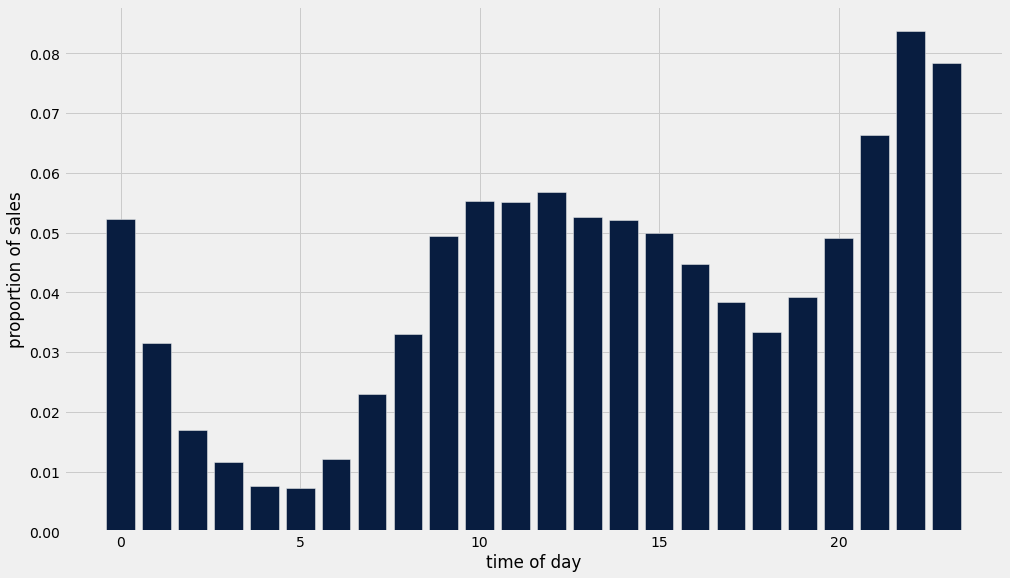

In [10]:
#消費時段分佈
graph, (plot1) = plots.subplots()
graph.set_size_inches(15, 9)
hour_table_online = Table().with_column("time", main_table.column("購買日期"))
hour_list_online = []
def get_time_of_day(time):
    hour = int(time[11:13])
    return hour
for time in hour_table_online.column(0):
    hour_list_online.append(get_time_of_day(time))
hour_table_online = Table().with_column("hour", hour_list_online).group("hour")
temp11 = 0
temp12 = []
for count in hour_table_online.column("count"):
    temp11 += count
for count in hour_table_online.column("count"):
    temp12.append(count/temp11)
hour_table_online = hour_table_online.with_column("ratio", temp12)
plots.bar(hour_table_online.column("hour"), hour_table_online.column("ratio"), color = "#081d40")
plots.xlabel("time of day")
plots.ylabel("proportion of sales")
print("消費時段分佈")

#EXPORT
#plots.savefig('消費時段分佈.png')

In [11]:
#消費次數分佈
num_order_count = []
num_order_proportion = []
num_order_max = max(user_data_table.column("消費次數"))
for i in range(1, num_order_max + 1):
    num_order_count.append(user_data_table.where("消費次數", are.equal_to(i)).num_rows)
for i in range(num_order_max):
    num_order_proportion.append(np.round(num_order_count[i] / user_data_table.num_rows * 100, 2))
num_order_list = range(1, num_order_max + 1)
num_order_proportion_cumulative = []
for i in range(num_order_max):
    if num_order_max > i > 0:
        num_order_proportion_cumulative.append(np.round(num_order_proportion[i] + num_order_proportion_cumulative[i-1], 2))
    elif i == 0:
        num_order_proportion_cumulative.append(num_order_proportion[i])
orders_table = Table().with_columns("消費次數", num_order_list,
                                    "佔比", num_order_proportion,
                                    "累積佔比", num_order_proportion_cumulative)
above8 = user_data_table.where("消費次數", are.above(7)).num_rows
print("消費次數分佈")
print("消費次數高於8次：" + str(above8) + "筆，佔：" + str(np.round(above8/user_data_table.num_rows * 100, 3)) + "%")
print("最高消費次數：" + str(num_order_max) + "次")
orders_table.where("消費次數", are.below(9))

#EXPORT
#orders_table.to_csv("消費次數分佈.csv")

消費次數分佈
消費次數高於8次：37筆，佔：0.162%
最高消費次數：18次


消費次數,佔比,累積佔比
1,78.23,78.23
2,14.05,92.28
3,4.47,96.75
4,1.79,98.54
5,0.75,99.29
6,0.39,99.68
7,0.16,99.84
8,0.07,99.91


In [12]:
#計算消費週期
temp_dict = {}
iii = 1
for i in range(main_table.num_rows):
    user = main_table.column("購買人電子信箱")[i]
    date = time_since_march31(main_table.column("購買日期")[i])
    if user not in temp_dict.keys():
        iii += 1
        temp_dict[user] = [date]
    elif date not in temp_dict[user]:
        temp_dict[user].append(date)
order_date_list = []
for user in temp_dict.keys():
    if user in user_data_table.column("電子信箱"):
        order_date_list.append(temp_dict[user])
order_date_list2 = []
order_date_list3 = []
order_date_list4 = []
order_date_list5 = []
order_date_list6 = []
for lst in order_date_list:
    if len(lst) == 2:
        order_date_list2.append(lst[:])
    elif len(lst) == 3:
        order_date_list3.append(lst[:])
    elif len(lst) == 4:
        order_date_list4.append(lst[:])
    elif len(lst) == 5:
        order_date_list5.append(lst[:])
    elif len(lst) > 5:
        order_date_list6.append(lst[:])
_2 = []
for lst in order_date_list2:
    diff = np.diff(lst)
    _2.append((sum(diff) / len(diff)))
avg_order_date_gap2 = abs(int(sum(_2) / len(_2)))
_3 = []
for lst in order_date_list3:
    diff = np.diff(lst)
    _3.append((sum(diff) / len(diff)))
avg_order_date_gap3 = abs(int(sum(_3) / len(_3)))
_4 = []
for lst in order_date_list4:
    diff = np.diff(lst)
    _4.append((sum(diff) / len(diff)))
avg_order_date_gap4 = abs(int(sum(_4) / len(_4)))
_5 = []
for lst in order_date_list5:
    diff = np.diff(lst)
    _5.append((sum(diff) / len(diff)))
avg_order_date_gap5 = abs(int(sum(_5) / len(_5)))
_6 = []
for lst in order_date_list6:
    diff = np.diff(lst)
    _6.append((sum(diff) / len(diff)))
avg_order_date_gap6 = abs(int(sum(_6) / len(_6)))
_total = []
num_multiple_orders = 0
for lst in order_date_list:
    diff = np.diff(lst)
    if len(diff) != 0:
        _total.append(sum(diff) / len(diff))
        num_multiple_orders += 1
avg_order_date_gap = abs(int(sum(_total) / len(_total)))
avg_order_gap_table = Table().with_columns("消費次數", [2,3,4,5,"6+"],
                                           "平均消費週期", [avg_order_date_gap2, avg_order_date_gap3, avg_order_date_gap4, avg_order_date_gap5, avg_order_date_gap6],
                                           "數據量", [len(order_date_list2), len(order_date_list3), len(order_date_list4), len(order_date_list5), len(order_date_list6)]
                                           )
print("平均消費週期：" + str(avg_order_date_gap) + "天" + "，數據量：", num_multiple_orders)
avg_order_gap_table

#EXPORT
#avg_order_gap_table.to_csv("平均消費週期.csv")

平均消費週期：99天，數據量： 4914


消費次數,平均消費週期,數據量
2,109,3188
3,89,1012
4,75,398
5,64,162
6+,50,154


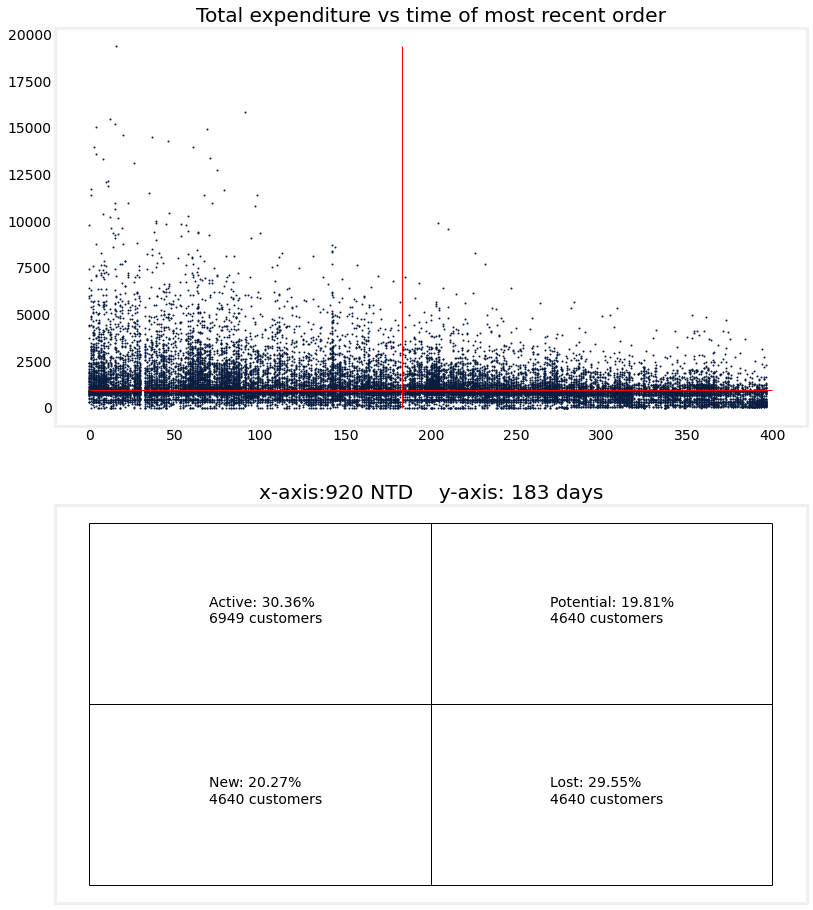

In [13]:
last_order = user_data_table.column("最近一次消費時間（天數）")
total_expenditure = user_data_table.column("總消費金額")
def expenditure_vs_time(time, expenditure):
    q2 = user_data_table.where("總消費金額", are.above_or_equal_to(expenditure)).where("最近一次消費時間（天數）", are.below_or_equal_to(time)).num_rows
    q3 = user_data_table.where("總消費金額", are.below(expenditure)).where("最近一次消費時間（天數）", are.below_or_equal_to(time)).num_rows
    q4 = user_data_table.where("總消費金額", are.below(expenditure)).where("最近一次消費時間（天數）", are.above(time)).num_rows
    q1 = user_data_table.where("總消費金額", are.above_or_equal_to(expenditure)).where("最近一次消費時間（天數）", are.above(time)).num_rows
    q1_val = np.round(q1 / user_data_table.num_rows * 100, 2) 
    q2_val = np.round(q2 / user_data_table.num_rows * 100, 2) 
    q3_val = np.round(q3 / user_data_table.num_rows * 100, 2)
    q4_val = np.round(q4 / user_data_table.num_rows * 100, 2) 
    graph, (plot1, plot2) = plots.subplots(2)
    graph.set_facecolor("white")
    graph.set_size_inches(12, 15)
    plot1.set_title("Total expenditure vs time of most recent order")
    plot1.set_facecolor("white")
    plot1.grid(False)
    for i in range(len(last_order)):
        plot1.plot(last_order[i], total_expenditure[i], marker='o', markersize=1, color = "#081d40")
    plot1.plot([time, time], [0, max(total_expenditure)], color = "red", lw = 1)
    plot1.plot([0, 400], [expenditure, expenditure], color = "red", lw = 1)
    plot2.set_title("x-axis:" + str(expenditure) + " NTD" + "    y-axis: "+ str(time) + " days")
    plot2.plot([0, 100], [50, 50], color = "black", lw = 1)
    plot2.plot([50, 50], [0, 100], color = "black", lw = 1)
    plot2.plot([0, 100], [0, 0], color = "black", lw = 1)
    plot2.plot([0, 0], [0, 100], color = "black", lw = 1)
    plot2.plot([0, 100], [100, 100], color = "black", lw = 1)
    plot2.plot([100, 100], [0, 100], color = "black", lw = 1)
    plot2.text(17.5, 72.5, ("Active: " + str(q2_val) + "%\n" +
                        str(q2) + " customers"), color = "black")
    plot2.text(17.5, 22.5, ("New: " + str(q3_val) + "%\n" +
                        str(q3) + " customers") , color = "black")
    plot2.text(67.5, 72.5, ("Potential: " + str(q1_val) + "%\n" +
                        str(q3) + " customers") , color = "black")
    plot2.text(67.5, 22.5, ("Lost: "+ str(q4_val) + "%\n" +
                        str(q3) + " customers"), color = "black")
    plot2.set_facecolor("white")
    plot2.grid(False)
    plot2.axes.get_xaxis().set_visible(False)
    plot2.axes.get_yaxis().set_visible(False)

#四分法 - 總消費金額 vs 最近一次消費時間

#INPUT START
time = 183
expenditure = 920
#INPUR END

expenditure_vs_time(time, expenditure)

#EXPORT
#plots.savefig('總消費金額 vs 最近一次消費時間.png')

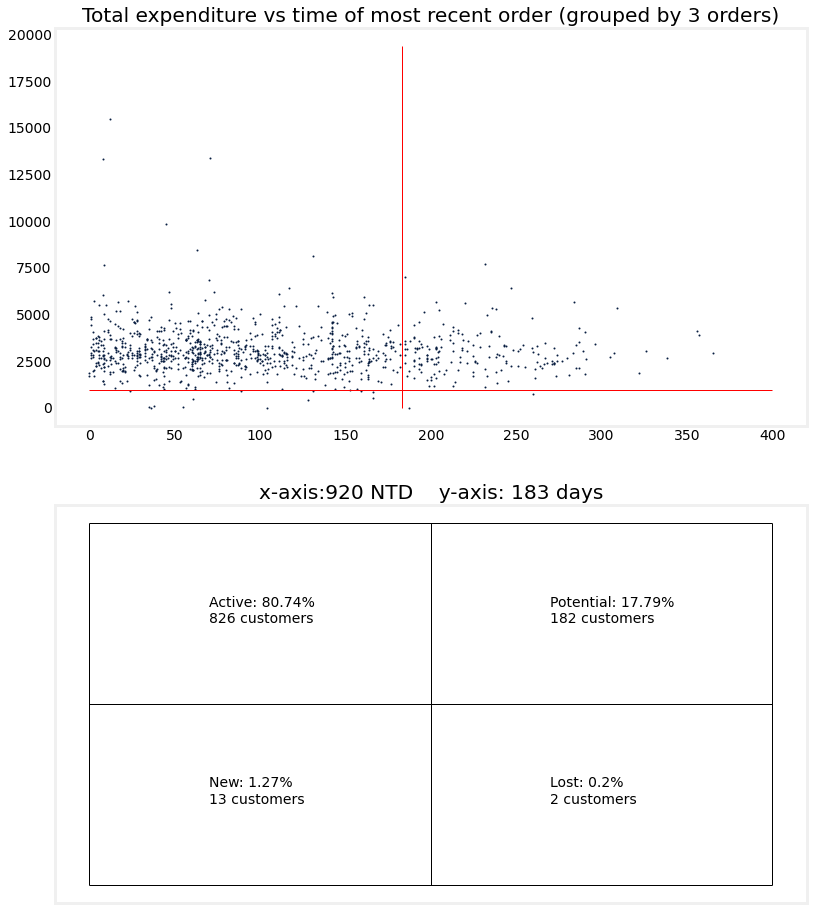

In [18]:
def by_num_orders(n, time, expenditure):
    q2_n_orders = user_data_table.where("總消費金額", are.above_or_equal_to(expenditure)).where("最近一次消費時間（天數）", are.below_or_equal_to(time)).where("消費次數", are.equal_to(n)).num_rows
    q3_n_orders = user_data_table.where("總消費金額", are.below(expenditure)).where("最近一次消費時間（天數）", are.below_or_equal_to(time)).where("消費次數", are.equal_to(n)).num_rows
    q4_n_orders = user_data_table.where("總消費金額", are.below(expenditure)).where("最近一次消費時間（天數）", are.above(time)).where("消費次數", are.equal_to(n)).num_rows
    q1_n_orders = user_data_table.where("總消費金額", are.above_or_equal_to(expenditure)).where("最近一次消費時間（天數）", are.above(time)).where("消費次數", are.equal_to(n)).num_rows
    q1_val_n_orders = np.round(q1_n_orders / user_data_table.where("消費次數", are.equal_to(n)).num_rows * 100, 2) 
    q2_val_n_orders = np.round(q2_n_orders / user_data_table.where("消費次數", are.equal_to(n)).num_rows * 100, 2) 
    q3_val_n_orders = np.round(q3_n_orders / user_data_table.where("消費次數", are.equal_to(n)).num_rows * 100, 2)
    q4_val_n_orders = np.round(q4_n_orders / user_data_table.where("消費次數", are.equal_to(n)).num_rows * 100, 2) 
    graph, (plot1, plot2) = plots.subplots(2)
    graph.set_facecolor("white")
    graph.set_size_inches(12, 15)
    plot1.set_title("Total expenditure vs time of most recent order (grouped by " + str(n) + " orders)")
    plot1.set_facecolor("white")
    plot1.grid(False)
    for i in range(len(last_order)):
        if user_data_table.column("消費次數")[i] == n:
            plot1.plot(last_order[i], total_expenditure[i], marker='o', markersize=1, color = "#081d40")
    plot1.plot([time, time], [0, max(total_expenditure)], color = "red", lw = 1)
    plot1.plot([0, 400], [expenditure, expenditure], color = "red", lw = 1)

    plot2.set_title("x-axis:" + str(expenditure) + " NTD" + "    y-axis: "+ str(time) + " days")
    plot2.plot([0, 100], [50, 50], color = "black", lw = 1)
    plot2.plot([50, 50], [0, 100], color = "black", lw = 1)
    plot2.plot([0, 100], [0, 0], color = "black", lw = 1)
    plot2.plot([0, 0], [0, 100], color = "black", lw = 1)
    plot2.plot([0, 100], [100, 100], color = "black", lw = 1)
    plot2.plot([100, 100], [0, 100], color = "black", lw = 1)
    plot2.text(17.5, 72.5, ("Active: " + str(q2_val_n_orders) + "%\n" +
                        str(q2_n_orders) + " customers"), color = "black")
    plot2.text(17.5, 22.5, ("New: " + str(q3_val_n_orders) + "%\n" +
                        str(q3_n_orders) + " customers") , color = "black")
    plot2.text(67.5, 72.5, ("Potential: " + str(q1_val_n_orders) + "%\n" +
                        str(q1_n_orders) + " customers") , color = "black")
    plot2.text(67.5, 22.5, ("Lost: "+ str(q4_val_n_orders) + "%\n" +
                        str(q4_n_orders) + " customers"), color = "black")
    plot2.set_facecolor("white")
    plot2.grid(False)
    plot2.axes.get_xaxis().set_visible(False)
    plot2.axes.get_yaxis().set_visible(False)
    
#四分法 - 控制消費次數   

#INPUT START
n_1 = 3 #訂單數
time_1 = 183
expenditure_1 = 920
#INPUT END

by_num_orders(n_1, time_1, expenditure_1)
#EXPORT
#plots.savefig("總消費金額 vs 最近一次消費時間（限消費" + str(n_1) + "次）.png")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/datascience/tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


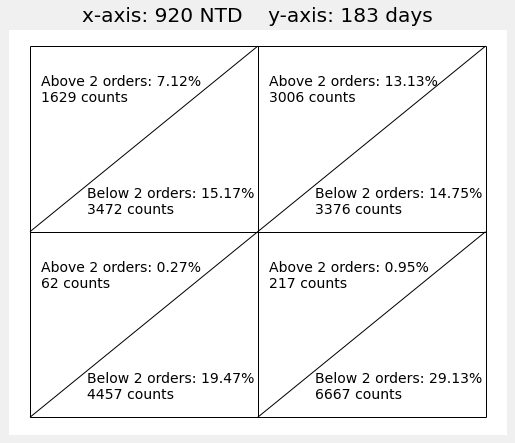

In [14]:
temp_table = user_data_table.with_column("all orders", order_date_list)

def by_n_in_time_to_expenditure(n, time, expenditure):
    result = ""
    s1, s2, s3, s4, s5, s6, s7, s8 = 0, 0, 0, 0, 0, 0, 0, 0
    ttl = temp_table.num_rows
    for i in range(temp_table.num_rows):
        if len(temp_table.column("all orders")[i]) >= n:
            #s1,3,5,7
            if temp_table.column("all orders")[i][-n] < time:
                #s1,3
                if temp_table.column("總消費金額")[i] >= expenditure:
                    s1 += 1
                    #result = "s1"
                else:
                    s3 += 1
                    #result = "s3"
            else:
                #s5,7
                if temp_table.column("總消費金額")[i] >= expenditure:
                    s5 += 1
                    #result = "s5"
                else:
                    s7 += 1
                    #result = "s7"
        else:
            #s2,4,6,8
            if temp_table.column("all orders")[i][-1] < time:
                #s1,3
                if temp_table.column("總消費金額")[i] >= expenditure:
                    s2 += 1
                    #result = "s2"
                else:
                    s4 += 1
                    #result = "s4"
            else:
                #s5,7
                if temp_table.column("總消費金額")[i] >= expenditure:
                    s6 += 1
                    #result = "s6"
                else:
                    s8 += 1
                    #result = "s8"
            
    graph, (plot2) = plots.subplots(1)
    graph.set_size_inches(8, 7)
    plot2.plot([0, 200], [100, 100], color = "black", lw = 1)
    plot2.plot([100, 100], [0, 200], color = "black", lw = 1)
    plot2.plot([0, 100], [100, 200], color = "black", lw = 1)
    plot2.plot([0, 200], [0, 200], color = "black", lw = 1)
    plot2.plot([100, 200], [0, 100], color = "black", lw = 1)
    plot2.plot([0, 200], [0, 0], color = "black", lw = 1)
    plot2.plot([0, 0], [0, 200], color = "black", lw = 1)
    plot2.plot([0, 200], [200, 200], color = "black", lw = 1)
    plot2.plot([200, 200], [0, 200], color = "black", lw = 1)
    plot2.set_facecolor("white")
    plot2.axes.get_xaxis().set_visible(False)
    plot2.axes.get_yaxis().set_visible(False)
    plot2.set_title("x-axis: " + str(expenditure) + " NTD    y-axis: " + str(time) + " days")
    plot2.text(5,170,"Above " + str(n) + " orders: " + str(np.round(s1 / ttl * 100, 2)) + "%\n" + str(s1) + " counts", color = "black")
    plot2.text(25,110,"Below " + str(n) + " orders: " + str(np.round(s2 / ttl * 100, 2)) + "%\n" + str(s2) + " counts", color = "black")
    plot2.text(5,70,"Above " + str(n) + " orders: " + str(np.round(s3 / ttl * 100, 2)) + "%\n" + str(s3) + " counts", color = "black")
    plot2.text(25,10,"Below " + str(n) + " orders: " + str(np.round(s4 / ttl * 100, 2)) + "%\n" + str(s4) + " counts", color = "black")
    plot2.text(105,170,"Above " + str(n) + " orders: " + str(np.round(s5 / ttl * 100, 2)) + "%\n" + str(s5) + " counts", color = "black")
    plot2.text(125,110,"Below " + str(n) + " orders: " + str(np.round(s6 / ttl * 100, 2)) + "%\n" + str(s6) + " counts", color = "black")
    plot2.text(105,70,"Above " + str(n) + " orders: " + str(np.round(s7 / ttl * 100, 2)) + "%\n" + str(s7) + " counts", color = "black")
    plot2.text(125,10,"Below " + str(n) + " orders: " + str(np.round(s8 / ttl * 100, 2)) + "%\n" + str(s8) + " counts", color = "black")

#四分法 - 控制週期內消費次數

#INPUT START
n_2 = 2
time_2 = 183
expenditure_2 = 920
#INPUT END

by_n_in_time_to_expenditure(n_2, time_2, expenditure_2)

#EXPORT
plots.savefig("總消費金額 vs 最近一次消費時間 （限天數內消費" + str(n_2) +"次）.png")

In [15]:
#其他數據
total_num_order = 0
for lst in order_date_list:
    total_num_order += len(lst)
total_num_order_gap_in_6_months = 0
for lst in order_date_list:
    for j in range(len(lst)):
        if j > 0 and abs(lst[j] - lst[j-1]) <= 183:
            total_num_order_gap_in_6_months += 1
rpr = np.round(total_num_order_gap_in_6_months / total_num_order * 100, 2)
total_revenue = sum(main_table.column("小計"))
print("總消費者數：" +  str(user_data_table.num_rows) + "人")
print("重複消費者數：" + str(user_data_table.where("消費次數", are.not_equal_to(1)).num_rows) + "人")
print("總營收：" + str(total_revenue) + "元")
print("RPR: " + str(rpr) + "%")

總消費者數：22886人
重複消費者數：4982人
總營收：28805726元
RPR: 23.18%
